# Atmospheric composition distribution by CAMS and IASI

### Main goal:
* Compare IASI and CAMS datasets for CO and O<sub>3</sub> (Level 2). - From 14.05.2019 on

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  
from matplotlib import animation
from IPython.display import HTML, display

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'O3'

# Define sensor
sensor = 'iasi'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 90

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2019-05-13'
end_date = '2019-05-14'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In days: ('2019-05-13', '2019-05-14')


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')

The file exists, it will not be downloaded again.


In [7]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-05-13 2019-05-14
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-19T18:46 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [8]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Download and read data as xarray

In [9]:
dates = sensor_download(sensor, sensor_type, component_nom, dates)

RESULTS
For 2019-05-13:
IASI_FORLI_O3_metopa_20190513_v20151001.nc is not available.
IASI_FORLI_O3_metopb_20190513_v20151001.nc is not available.
IASI_FORLI_O3_metopc_20190513_v20151001.nc is not available.
For 2019-05-14:
IASI_FORLI_O3_metopa_20190514_v20151001.nc was downloaded.
IASI_FORLI_O3_metopb_20190514_v20151001.nc was downloaded.
IASI_FORLI_O3_metopc_20190514_v20151001.nc is not available.


In [10]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

/tmp/ipykernel_2549314/3375918951.py:69: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.DataArray 'sensor_column' (time: 1, latitude: 180, longitude: 360)>
array([[[       nan, 0.12976611,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan, 0.12083906, 0.12430965, ..., 0.1250074 ,
         0.1282189 ,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  datetime64[ns] 2019-05-14
  * time        (time) datetime64[ns] 2019-05-14
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [11]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.
The sensor component units have been converted from molec cm-2 to DU.


<xarray.DataArray 'sensor_column' (time: 1, latitude: 180, longitude: 360)>
array([[[         nan, 290.50916774,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 270.52407539, 278.29371843, ..., 279.85578785,
         287.0454243 ,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  datetime64[ns] 2019-05-14
  * time        (time) datetime64[ns] 2019-05-14
Attributes:
    units:    DU

## 4. Match data

In [12]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR EST. TIME: 2019-05-14T00:00:00.000000000
The sensor dataset does not contain data to apply the averaging kernels.
The model dataset does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,delta_time,time,sensor_column,step_index,model_column
0,-89.5,-179.5,2019-05-14,2019-05-14,NaN,0,241.387924
1,-89.5,-178.5,2019-05-14,2019-05-14,290.509168,0,241.359802
2,-89.5,-177.5,2019-05-14,2019-05-14,NaN,0,241.341141
3,-89.5,-176.5,2019-05-14,2019-05-14,NaN,0,241.313248
4,-89.5,-175.5,2019-05-14,2019-05-14,NaN,0,241.295929
...,...,...,...,...,...,...,...
64795,89.5,175.5,2019-05-14,2019-05-14,NaN,0,402.950348
64796,89.5,176.5,2019-05-14,2019-05-14,NaN,0,402.960114
64797,89.5,177.5,2019-05-14,2019-05-14,NaN,0,402.972443
64798,89.5,178.5,2019-05-14,2019-05-14,NaN,0,402.981476


## 5. Merge data and calculate difference

In [13]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor)
merge_table

sensor_column  step_index  model_column  \
latitude longitude time                                                  
-89.5    -179.5    2019-05-14            NaN           0    241.387924   
         -178.5    2019-05-14     290.509168           0    241.359802   
         -177.5    2019-05-14            NaN           0    241.341141   
         -176.5    2019-05-14            NaN           0    241.313248   
         -175.5    2019-05-14            NaN           0    241.295929   
...                                      ...         ...           ...   
 89.5     175.5    2019-05-14            NaN           0    402.950348   
          176.5    2019-05-14            NaN           0    402.960114   
          177.5    2019-05-14            NaN           0    402.972443   
          178.5    2019-05-14            NaN           0    402.981476   
          179.5    2019-05-14            NaN           0    402.996094   

                               difference  
latitude longitude time                    
-89.5    -179.5    2019-05-14         NaN  
         -178.5    2019-05-14   49.149365  
         -177.5    2019-05-14         NaN  
         -176.5    2019-05-14         NaN  
         -175.5    2019-05-14         NaN  
...                                   ...  
 89.5     175.5    2019-05-14         NaN  
          176.5    2019-05-14         NaN  
          177.5    2019-05-14         NaN  
          178.5    2019-05-14         NaN  
          179.5    2019-05-14         NaN  

[64800 rows x 4 columns]

In [14]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,sensor_column,step_index,model_column,difference
count,41513.000000,64800.0,64800.000000,41513.000000
mean,307.784169,0.0,312.036588,2.698039
std,57.083638,0.0,60.507311,17.351358
min,198.245303,0.0,235.361572,-106.141990
25%,263.399456,0.0,263.563324,-5.563340
50%,288.498265,0.0,287.370026,0.821761
75%,339.033734,0.0,355.543709,8.937350
max,585.497307,0.0,494.159668,131.957548


## 6. Show comparison plots

### Select plot dates

In [15]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2019-05']


### Select plot extent

In [16]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 90))


### Compare CAMS and IASI total columns

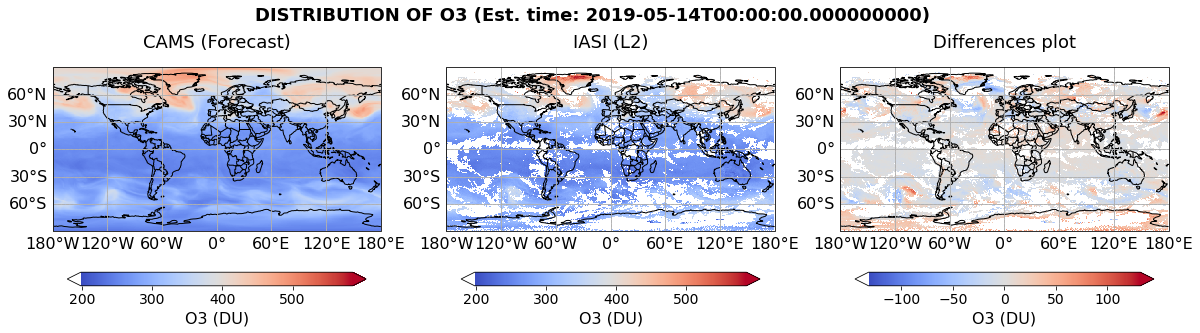

In [17]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale =  'coolwarm'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.9, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [18]:
coords_search_list = (50, 15,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

,,,,,sensor_column,step_index,model_column,difference
lat_search,lon_search,latitude,longitude,time,,,,
50,15,49.5,14.5,2019-05-14,437.094993,0,403.476654,33.618339
4,10,3.5,9.5,2019-05-14,268.632217,0,272.880646,-4.248428
20,30,19.5,29.5,2019-05-14,259.970190,0,266.535278,-6.565088


## 8. Scatter plots by bbox

Fit equation: O3_model = O3_sensor * 0.93 + (1.99E+01)
Coefficient of determination (R2): 0.91


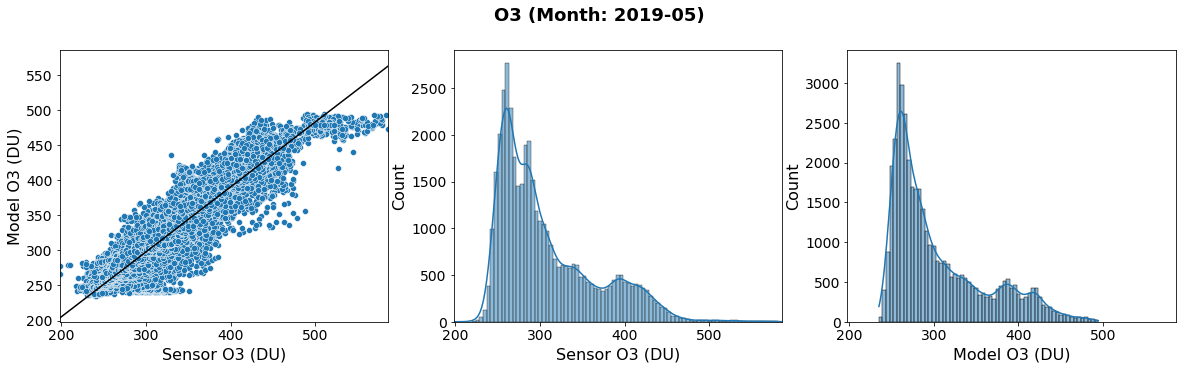

In [19]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [20]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2019-05-14,"((-180, -90), (180, 90))",0.907984,0.926503,19.923304


## 9. Scatter plots by season

Fit equation: O3_model = O3_sensor * 0.93 + (1.99E+01)
Coefficient of determination (R2): 0.91


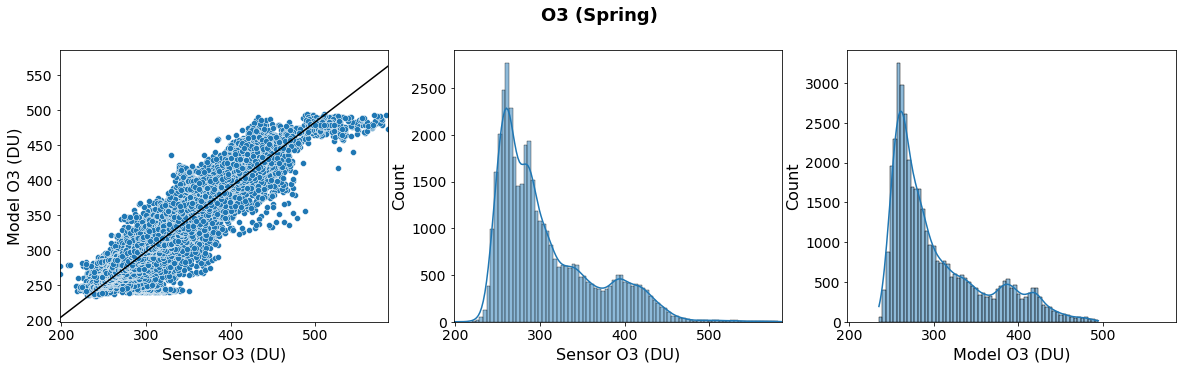

In [21]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [22]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Spring,"((-180, -90), (180, 90))",0.907984,0.926503,19.923304


## 10. Scatter plots by country (Google API required!)

In [23]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [24]:
#summary